## Note
#### This notebook need to be upload to the joinquant.com research module, so that we can calculate the NGE factor from the data source jqdata
#### I have already downloaded the calculated NGE factors, just run the "pd.read_csv('NGE_df.csv')" cell below 

In [ ]:
from jqdata import * # 未上传至聚宽平台请注释掉这行
import pandas as pd 
import numpy as np
import talib
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import pickle
# from scipy.stats import ttest_1samp
from sys import getsizeof
import warnings
import datetime as dt
warnings.filterwarnings('ignore')  #过滤代码运行过程中烦人的警告

In [ ]:
def Indicators(value):
    '''
    PARAMETERS
    value:t级别净值序列,含初始净值
    hold_freq:t级别（调仓周期）
    t_days:交易日序列,只用于计算跨月收益集中度t_hhi,len(t_days) = len(value) - 1
    
    RETURN 
    result:策略各项指标,可自行增删
    '''
    from scipy.stats import skew, kurtosis, norm
    #盈亏比
    def PlRatio(value):
        value = value[1:]-value[:-1]
        ratio = -value[value>0].mean()/value[value<0].mean()
        return ratio
    #日胜率,日基准收益为0
    def WinRate(Returns):
        pos = sum(Returns > 0)
        neg = sum(Returns < 0)
        return pos/(pos+neg)
    #最大回撤
    def MaxDrawBack(value):
        i = np.argmax(np.maximum.accumulate(value)-value)  # 结束位置
        if i == 0:
            return 0
        j = np.argmax(value[:i])  # 开始位置
        return (value[j]-value[i])/(value[j])
    #最长回撤时间，水下时间
    def MaxDrawBackDays(value):
        maxValue = 0
        maxValueIndex = []
        for k,v in enumerate(value):
            if v >= maxValue:
                maxValue = v
                maxValueIndex.append(k)
        last = len(value)-maxValueIndex[-1]-1 #回测最后处于最长回撤时期
        if len(maxValueIndex) == 1: #未创新高
            return last
        else:
            maxValueIndex = pd.Series(maxValueIndex)
            maxValueIndex -= maxValueIndex.shift(1) 
            maxValueIndex = maxValueIndex.dropna().values
            return max(maxValueIndex.max(),last) 
    #下行波动率
    def UnderVo(Returns):
        sigma = 0
        num = len(Returns)
        for k,r in enumerate(Returns):
            rMean = np.mean(Returns[:k])
            if r < rMean:
                sigma += (r-rMean)**2
        sigma = np.sqrt(sigma*250/num)
        return sigma
    
    #收益集中度  ret：收益率序列Series，index=date
    def getHHI(ret): 
        if ret.shape[0]<=2:
            return np.nan
        weight=ret/ret.sum()
        hhi=(weight**2).sum()
        hhi=(hhi-ret.shape[0]**-1)/(1.-ret.shape[0]**-1)
        return hhi
    #+/-/跨月收益集中度 
    def ReturnsConcentration(ret):
        pos_ret = ret[ret>0]
        neg_ret = ret[ret<0]
        pos_hhi = getHHI(pos_ret) # concentration of positive returns per bet
        neg_hhi = getHHI(neg_ret) # concentration of negative returns per bet
        t_hhi = getHHI(ret.groupby(pd.TimeGrouper(freq='M')).count()) # concentr. bets/month
        return pos_hhi,neg_hhi,t_hhi
    
    #PSR #ret: 1darray,1d收益率序列threshold:夏普率参照 rf: 年化无风险收益率
    def calcPsr(ret,sharpe,threshold=0,rf=0): 
        skw = skew(ret)
        kur = kurtosis(ret,fisher=False) #fisher=False:正态分布峰度=3
        prob = norm.cdf(((sharpe-threshold)*np.sqrt(ret.shape[0]))/np.sqrt(1-skw*sharpe+0.25*(kur-1)*sharpe**2))
        return prob #夏普率大于基准的概率
    #计算
    value=np.array(value)
    value=value/value[0] #每日净值 1darray
    value1=pd.Series(value)
    Returns=value1.pct_change(1).dropna().values #每日收益率 1darray
    ###
    TotalRetn = round(value[-1]*100-100,2) #总收益
    AnnualRetn= round(pow(value[-1],250/(len(value[1:])))*100-100,2) #年化收益
    Plr = round(PlRatio(value),2) #盈亏比
    Wr  = round(WinRate(Returns)*100,2) #日胜率
    Volatility     = round(np.sqrt(Returns.var()*250)*100,2) #年化波动率
    SharpRatio     = round((AnnualRetn)/Volatility,2) #年化夏普比
    # PSR
    PSRatio        = round(calcPsr(ret=Returns,sharpe=SharpRatio,threshold=1,rf=0),2) #概率夏普比 
    ###
    MaxDrawback    = round(MaxDrawBack(value)*100,2) #最大回撤
    KMRatio        = round(AnnualRetn/MaxDrawback,2) #卡玛比率
    MaxDrawbackDays= int(MaxDrawBackDays(value)) #最长回撤时间
    SortinoRatio   = round((AnnualRetn-4)/UnderVo(Returns)/100,2) #索提诺比率
    # HHI
#     Returns_s      = pd.Series(Returns)
#     Returns_s.index  = pd.to_datetime(t_days) 
#     HHI = getHHI(ret = Returns_s) #收益集中度
#     pos_hhi,neg_hhi,t_hhi = ReturnsConcentration(ret = Returns_s)
    ###
    Returns2 = np.sort(Returns)
    Max2  = round(Returns2[0]*100,2) #最大单日回撤
    var5  = round(Returns2[int(len(Returns2)*0.05)]*100,2) #收益率5%分位数
    '''
    以下输出值按需增删
    '''
    columns=['总收益','年化收益','波动率','夏普比','最大回撤','日胜率','盈亏比','最长回撤日数','calmar比率','单期最大回撤']
    data=[[TotalRetn,AnnualRetn,Volatility,SharpRatio,MaxDrawback,Wr,Plr,MaxDrawbackDays,KMRatio,Max2]]
    result=pd.DataFrame(columns=columns,data=data)
    return result
def calc_daily_separated_data(sig_data_daily,pre_data_daily,sig_slice,pre_slice,start_price,MA_window=None):
    # 信号开始
    sig_op = sig_slice[0] - 1
    # 信号结束
    sig_ed = sig_slice[1] - 1
    
    # 预测区间
    pre_op = pre_slice[0] - 1
    pre_ed = pre_slice[1] - 1

    sig_df = sig_data_daily[1]#1为df所在的位置
    
    sig_bars = sig_data_daily[0]
    pre_bars = pre_data_daily[0]
    # 将index的df转换为array
    if isinstance(sig_bars, pd.DataFrame):
        sig_bars = sig_bars.values
    if isinstance(pre_bars, pd.DataFrame):
        pre_bars = pre_bars.values
        
    if start_price == 'today_open':
        p_start = sig_df['open'][1]
    if start_price == 'yesterday_close':
        p_start = sig_df['close'][0]

    
    sig_price = []
    sig_volume = []
    pre_price = []
    a = []
# 这里是直接取区间的bars,根据bar来直接计算相关指标
    for i, bar_s in enumerate(sig_bars):
        a.append(bar_s[4])
        # 取信号部分
        if i==0 and sig_op==0:
            sig_price.append(p_start)
        if (sig_op<=i and i<=sig_ed):
            sig_price.append(bar_s[4])
            sig_volume.append(bar_s[5])
            
    for j, bar_p in enumerate(pre_bars):   
        # 取目标区间部分计算预期收益率
        if (pre_op<=j and j<=pre_ed):
            pre_price.append(bar_p[4])

    sig_p = np.array(sig_price)
    sig_v = np.array(sig_volume)
    pre_p = np.array(pre_price)  
    pre_retn = pre_p[-1] / pre_p[0] - 1

    def _calc_daily_sig(sig_p, sig_v, MA_window):
            #信号计算模块
        if not MA_window:
#             signal = sig_p[-1] / sig_p[0] - 1
            signal = sig_p[-1] - sig_p.mean()
        else:
            _MA = talib.MA(sig_p, MA_window)
            MA = _MA[numpy.logical_not(numpy.isnan(_MA))]
            signal = MA[-1] / MA[0] - 1
        return signal
    signal = _calc_daily_sig(sig_p,sig_v,MA_window)
    
    return sig_df.index[1], signal, pre_retn #1位置为当天的日期

def net_value(returns, benchmark=None,commission=0.0000):
    dates = returns.index
    net_value_se = pd.Series(((1-commission)*(1 + returns.values)).cumprod(),index=dates,name='intraday')
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-white')
    fig = plt.figure(figsize=(16,9))
    ax1 = plt.axes()
    ax1.set_xlabel('date')
    ax1.set_ylabel('net_value')
    ax1.set_title(net_value_se.name + '  Net Value')
    # 净值曲线
    ax1.plot(net_value_se,linestyle='-',label='Net value')
    # jis
    graph_bottom = plt.ylim()[0]
    graph_top = plt.ylim()[1]
    graph_height = graph_top - graph_bottom
    
    indi = Indicators(net_value_se)
    indi =indi.rename(index={0:net_value_se.name})
    if benchmark is not None:

        # benchmark净值曲线
        ax1.plot(benchmark_net_value,linestyle='-.',color='grey',label=bench_code)
        raph_bottom = plt.ylim()[0]
        graph_top = plt.ylim()[1]
        graph_height = graph_top - graph_bottom
    # 超额收益曲线
        excess = net_value_se.pct_change().dropna() - benchmark_net_value.pct_change().dropna()
        ax1.bar(x=excess.index,height=(0.2*graph_height/excess.min())*excess.values,bottom=1,color='orange',label='Excess return rate')
        indi_benchmark = Indicators(benchmark_net_value)
        indi_benchmark =indi_benchmark.rename(index={0:bench_code})
        indi = indi.append(indi_benchmark)
    #日亏损
    rt = net_value_se.pct_change().dropna()
    rt[rt>0]=0
    drawdown_se = rt
    ax1.bar(x=drawdown_se.index,height=(-0.2*graph_height/rt.min())*drawdown_se.values,bottom=graph_top,color='silver',label='Drawdown')
    
    
    plt.legend()
    plt.show()

    return indi

def calc_signal_and_predict(sig_data_raw,pre_data_raw,sig_slice,pre_slice,start_price,MA_window=None):
    data_list = []
    for sig_data_daily, pre_data_daily in zip(sig_data_raw,pre_data_raw):
        data_list.append(calc_daily_separated_data(sig_data_daily,pre_data_daily,sig_slice,pre_slice,start_price,MA_window))
    columns = ['date', 'signal', 'predict_retn']
    return pd.DataFrame(data_list, columns=columns)

def _one_trade(sig, pre, oritation):
    if sig > 0:
        retn = pre
    elif sig < 0:
        retn = -pre
    else:
        retn = 0
    if oritation == 'momentum':
        return retn
    elif oritation == 'reverse':
        return -retn
    '''
    PARAMETERS
    value:t级别净值序列,含初始净值
    hold_freq:t级别（调仓周期）
    t_days:交易日序列,只用于计算跨月收益集中度t_hhi,len(t_days) = len(value) - 1
    
    RETURN 
    result:策略各项指标,可自行增删
    '''
    from scipy.stats import skew, kurtosis, norm
    #盈亏比
    def PlRatio(value):
        value = value[1:]-value[:-1]
        ratio = -value[value>0].mean()/value[value<0].mean()
        return ratio
    #日胜率,日基准收益为0
    def WinRate(Returns):
        pos = sum(Returns > 0)
        neg = sum(Returns < 0)
        return pos/(pos+neg)
    #最大回撤
    def MaxDrawBack(value):
        i = np.argmax(np.maximum.accumulate(value)-value)  # 结束位置
        if i == 0:
            return 0
        j = np.argmax(value[:i])  # 开始位置
        return (value[j]-value[i])/(value[j])
    #最长回撤时间，水下时间
    def MaxDrawBackDays(value):
        maxValue = 0
        maxValueIndex = []
        for k,v in enumerate(value):
            if v >= maxValue:
                maxValue = v
                maxValueIndex.append(k)
        last = len(value)-maxValueIndex[-1]-1 #回测最后处于最长回撤时期
        if len(maxValueIndex) == 1: #未创新高
            return last
        else:
            maxValueIndex = pd.Series(maxValueIndex)
            maxValueIndex -= maxValueIndex.shift(1) 
            maxValueIndex = maxValueIndex.dropna().values
            return max(maxValueIndex.max(),last) 
    #下行波动率
    def UnderVo(Returns):
        sigma = 0
        num = len(Returns)
        for k,r in enumerate(Returns):
            rMean = np.mean(Returns[:k])
            if r < rMean:
                sigma += (r-rMean)**2
        sigma = np.sqrt(sigma*250/num)
        return sigma
    
    #收益集中度  ret：收益率序列Series，index=date
    def getHHI(ret): 
        if ret.shape[0]<=2:
            return np.nan
        weight=ret/ret.sum()
        hhi=(weight**2).sum()
        hhi=(hhi-ret.shape[0]**-1)/(1.-ret.shape[0]**-1)
        return hhi
    #+/-/跨月收益集中度 
    def ReturnsConcentration(ret):
        pos_ret = ret[ret>0]
        neg_ret = ret[ret<0]
        pos_hhi = getHHI(pos_ret) # concentration of positive returns per bet
        neg_hhi = getHHI(neg_ret) # concentration of negative returns per bet
        t_hhi = getHHI(ret.groupby(pd.TimeGrouper(freq='M')).count()) # concentr. bets/month
        return pos_hhi,neg_hhi,t_hhi
    
    #PSR #ret: 1darray,1d收益率序列threshold:夏普率参照 rf: 年化无风险收益率
    def calcPsr(ret,sharpe,threshold=0,rf=0): 
        skw = skew(ret)
        kur = kurtosis(ret,fisher=False) #fisher=False:正态分布峰度=3
        prob = norm.cdf(((sharpe-threshold)*np.sqrt(ret.shape[0]))/np.sqrt(1-skw*sharpe+0.25*(kur-1)*sharpe**2))
        return prob #夏普率大于基准的概率
    #计算
    value=np.array(value)
    value=value/value[0] #每日净值 1darray
    value1=pd.Series(value)
    Returns=value1.pct_change(1).dropna().values #每日收益率 1darray
    ###
    TotalRetn = round(value[-1]*100-100,2) #总收益
    AnnualRetn= round(pow(value[-1],250/(len(value[1:])))*100-100,2) #年化收益
    Plr = round(PlRatio(value),2) #盈亏比
    Wr  = round(WinRate(Returns)*100,2) #日胜率
    Volatility     = round(np.sqrt(Returns.var()*250)*100,2) #年化波动率
    SharpRatio     = round((AnnualRetn)/Volatility,2) #年化夏普比
    # PSR
    PSRatio        = round(calcPsr(ret=Returns,sharpe=SharpRatio,threshold=1,rf=0),2) #概率夏普比 
    ###
    MaxDrawback    = round(MaxDrawBack(value)*100,2) #最大回撤
    KMRatio        = round(AnnualRetn/MaxDrawback,2) #卡玛比率
    MaxDrawbackDays= int(MaxDrawBackDays(value)) #最长回撤时间
    SortinoRatio   = round((AnnualRetn-4)/UnderVo(Returns)/100,2) #索提诺比率
    # HHI
#     Returns_s      = pd.Series(Returns)
#     Returns_s.index  = pd.to_datetime(t_days) 
#     HHI = getHHI(ret = Returns_s) #收益集中度
#     pos_hhi,neg_hhi,t_hhi = ReturnsConcentration(ret = Returns_s)
    ###
    Returns2 = np.sort(Returns)
    Max2  = round(Returns2[0]*100,2) #最大单日回撤
    var5  = round(Returns2[int(len(Returns2)*0.05)]*100,2) #收益率5%分位数
    '''
    以下输出值按需增删
    '''
    columns=['总收益','年化收益','波动率','夏普比','最大回撤','日胜率','盈亏比','最长回撤日数','calmar比率','单期最大回撤']
    data=[[TotalRetn,AnnualRetn,Volatility,SharpRatio,MaxDrawback,Wr,Plr,MaxDrawbackDays,KMRatio,Max2]]
    result=pd.DataFrame(columns=columns,data=data)
    return result

In [ ]:
################################################取期权#########################################################    
#######起始日期
start_date_option = '2015-05-01'
######终止日期
end_date_option = '2023-02-23'
######标的https://docs.qq.com/sheet/DTGZqRE5UbWlla2FH?tab=eqwbzr
# 上证50ETF期权， 510050.XSHG,上市时间为2015-02-09，从2015-05-01开始取数据,实际上2017-01-03号才开始有数据data_list[410:]
# 沪深300ETF期权（上海交易所），510300.XSHG，上市时间为2019-12-23
# 沪深300ETF期权（深圳交易所），159919，上市时间为2019-12-23
# 沪深300股指期货期权，IO，看涨期权：IO合约月份-C-行权价格，如IO2302-C-3350，看跌期权：IO合约月份-P-行权价格
# 中证1000股指期货期权，MO

underlying_asset_name = '50ETF'
option_file_name = 'option_contracts_{}_({}to{}).pkl'.format(underlying_asset_name,
                                                             start_date_option,
                                                             end_date_option)
option_folder_name = 'contracts_list'
option_path = option_folder_name + '/' + option_file_name

with open (option_path,'rb') as op_f:
    option_data_raw = pickle.load(op_f)
data_list = option_data_raw
# data_list = data_list[-20:]
# data_list中为（当天日期，
#                array（【期权代码，敲定价，到期时间，call？put，复权？没复权为M】,【】））

########################取ETF数据########################################################
start_date_etf = '2015-01-01'
end_date_etf = '2023-04-06'

# 上证50etf 2005-03-23上市
etf_code = '510050.XSHG'
######采样频率/min
freq = 1

etf_folder_name = 'bar_data'
etf_file_name = 'etf{}_{}min({}to{}).pkl'.format(etf_code,freq,
                                                 start_date_etf,
                                                 end_date_etf)
etf_path = etf_folder_name + '/' + etf_file_name
with open (etf_path,'rb') as etf_f:
    etf_raw_data = pickle.load(etf_f)
etf_bar_list = etf_raw_data[26:-28]
########################################取移仓换月数据###############################################
IH_adjusted = pd.read_csv('my_data/IH_data.csv')
##################################################################################################


In [ ]:
# 0_表示t-1天，1_表示t天, 2_表示t+1天
future_adjusted = IH_adjusted.set_index('date').loc['2017-01-03':'2023-02-01']
sig_and_pre_adjusted = pd.DataFrame()
sig_and_pre_adjusted['signal'] = np.log(future_adjusted['1_14:00'] / future_adjusted['0_15:00']) 
sig_and_pre_adjusted['predict_retn'] = np.log(future_adjusted['1_14:30'] / future_adjusted['1_14:00'])
sig_and_pre_adjusted.index = pd.to_datetime(sig_and_pre_adjusted.index)

In [ ]:
# 计算隐含波动率 从而计算gamma值
from scipy.stats import norm
n = norm.pdf
N = norm.cdf
def BSM_option_price(call_or_put, S,K,T,r,v,q=0.0):
    '''
    call_or_put: 'call', 'put'
    S: underlying assets price
    K: strike price
    T: time to expiration
    r: risk free rate
    v: volatility
    q: dividends
    '''
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    # call
    if call_or_put == 'c':
        option_price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    elif call_or_put == 'p':
        option_price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    else:
        raise ValueError('can not decide call or put!')
    return option_price

def BSM_vega(call_or_put,S,K,T,r,v,q=0.0):
    '''
    call_or_put: 'call', 'put'
    S: underlying assets price
    K: strike price
    T: time to expiration
    r: risk free rate
    v: volatility
    q: dividends
    '''
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    return S * np.sqrt(T)*n(d1)

def implied_volatility(real_option_price, call_or_put,S, K, T, r):
    '''
    call_or_put: 'call', 'put'
    S: underlying assets price
    K: strike price
    T: time to expiration
    r: risk free rate
    v: volatility
    q: dividends
    '''
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    
    implied_vol = 0.5#初始值
    for i in range(0, MAX_ITERATIONS):
        price = BSM_option_price(call_or_put, S, K, T, r, implied_vol)
        vega = BSM_vega(call_or_put, S, K, T, r, implied_vol)
        diff = real_option_price - price  # 我们的根
        if (abs(diff) < PRECISION):
            return implied_vol
        if not (np.isnan(vega) or implied_vol + diff/vega < 1.0e-5):
            implied_vol = implied_vol + diff/vega # f(x) / f'(x)
        else:        
            if implied_vol >= 1e5:
                return 1e5
            else:
                return implied_vol

import copy
import scipy.stats as si

#######################################################################################
def get_one_code_data(one_code_arr, datetime, include_now):

    bar = get_bars(one_code_arr[0], 1, unit='1m',
                   fields=('close','open_interest'),
                   include_now=include_now, end_dt=datetime, fq_ref_date=None, df=False)#include_now = True取当天收盘，False收盘前半小时
    if (len(bar) != 0):
        one_code_arr[6] = bar[0][0]    # insert real option close price
        one_code_arr[2] = bar[0][1] # insert open_interest
    one_code_arr[5] = (one_code_arr[4] - datetime) / pd.Timedelta(1,'d')
###################################################################################
# #对每个code_arr进行计算
def calc_NGE(code_daily, underlying_data_daily,end_time, include_now=True):
    V_Inplied_vol = np.vectorize(implied_volatility,excluded=['S','r'])# vectorize 
    date = code_daily[0] # current date
    if type(code_daily[1]) is np.ndarray:
        code_temp = copy.deepcopy(code_daily[1]) 
        code_arr = np.insert(code_temp,[2,2,3,3,3],np.NaN, axis=1)
        code_arr[:,4] = code_arr[:,4].astype(datetime64) + np.timedelta64(54000,'s')# 转换日期格式并添加小时分钟秒,结束为行权日当天15:00

        dt = pd.to_datetime(str(date)+' '+ end_time)# 结束时间
        underlying_open = underlying_data_daily[1].iloc[1]['open']
        df = underlying_data_daily[0]
        underlying_arr = underlying_data_daily[0].set_index('date').loc[:dt,'close'].values #价格序列arr
        underlying_close = underlying_arr[-1]  

        # 取time to expire和open interest
        # #这部分用矢量化计算会快一点   
        for _, one_code_arr in enumerate(code_arr):
            get_one_code_data(one_code_arr, dt, include_now=include_now)
        ##########################################################  
        # code_arr[code,strike_price,open_interest,nan,expiration date,T,market option price,std,cp,MA]


    #         alpha = (index_data[1] / (code_arr[:,1] * 1000)).astype('float64')
        # underlying assets 换成50etf 不需要乘1000
        S_price = underlying_close

        alpha = (S_price / (code_arr[:,1])).astype('float64')

        #   分钟级波动率 化为年化波动率
    #     std = np.std(np.diff(np.log(underlying_arr))) * np.sqrt(240 * 252)
        #用隐含波动率代替历史波动率
        # 计算隐含波动率
        real_option_price = code_arr[:,6] #option price in real world
        call_or_put = code_arr[:,8] # call or put 'c'or'p
        S = underlying_close # underlying assets price
        K = code_arr[:,1] # strike price
        T = (code_arr[:,5].astype('float64')) / 365   # 日化变年化,time to expirate
        r = 0.021 #无风险利率，用的年化1天期国债逆回购利率（固定值，后面添加变动值）
        std = V_Inplied_vol(real_option_price, call_or_put, underlying_close, K, T, r)
        code_arr[:,7] = std
        d = (np.log(alpha) + (r+0.5*(std**2))*T) / (std * np.sqrt(T))

    #     gamma = np.exp(-r*T - 0.5 * d**2) / (std *np.sqrt(2*np.pi*T)) #股票价格一乘一除抵消了
    #     gamma = si.norm.pdf(d) / (S_price * std * np.sqrt(T))
        gamma = si.norm.pdf(d) / (std * np.sqrt(T)) # 股票价格一乘一除抵消了
        code_arr[:,1] = alpha
        code_arr[:,3] = gamma

        code_drop_weird = code_arr[code_arr[:,5]>=0.05] #日期在最后半个小时之前
        # 将Call 与 Put 拆出来
        call_option = code_drop_weird[code_drop_weird[:,8]=='c']
        put_option = code_drop_weird[code_drop_weird[:,8]=='p']

    #     deep out of money(DOTM) alpha<0.955
        #     out of the money(OTM) 0.955<alpha<0.985
        #     at the money(ATM) 0.985<alpha<1.015
        #     in the money(ITM) 1.015<alpha<1.045
        #     deep in the money(DITM) 1.045<alpha
        call_DOTM = call_option[call_option[:,1] < 0.955]
        put_DITM = put_option[put_option[:,1] < 0.955]

        call_DITM = call_option[call_option[:,1] > 1.045]
        put_DOTM = put_option[put_option[:,1] > 1.045]

        call_OTM = call_option[np.logical_and(call_option[:,1]>=0.955, call_option[:,1]<0.985)]
        put_ITM  = put_option[np.logical_and(put_option[:,1]>=0.955, put_option[:,1]<0.985)]

        call_ITM = call_option[np.logical_and(call_option[:,1]>=1.015, call_option[:,1]<1.045)]
        put_OTM  = put_option[np.logical_and(put_option[:,1]>=1.015, put_option[:,1]<1.045)]

        call_ATM = call_option[np.logical_and(call_option[:,1]>=0.985, call_option[:,1]<1.015)]
        put_ATM  = put_option[np.logical_and(put_option[:,1]>=0.985, put_option[:,1]<1.015)]

        NGE_all = call_option[:,2].astype('float64')@call_option[:,3].astype('float64') - \
                  put_option[:,2].astype('float64')@put_option[:,3].astype('float64') 

        NGE_DITM = call_DITM[:,2].astype('float64')@call_DITM[:,3].astype('float64') - \
                   put_DITM[:,2].astype('float64')@put_DITM[:,3].astype('float64') 

        NGE_DOTM = call_DOTM[:,2].astype('float64')@call_DOTM[:,3].astype('float64') - \
                   put_DOTM[:,2].astype('float64')@put_DOTM[:,3].astype('float64') 

        NGE_ITM = call_ITM[:,2].astype('float64')@call_ITM[:,3].astype('float64') - \
                  put_ITM[:,2].astype('float64')@put_ITM[:,3].astype('float64') 

        NGE_OTM = call_OTM[:,2].astype('float64')@call_OTM[:,3].astype('float64') - \
                  put_OTM[:,2].astype('float64')@put_OTM[:,3].astype('float64') 

        NGE_ATM = call_ATM[:,2].astype('float64')@call_ATM[:,3].astype('float64') - \
                  put_ATM[:,2].astype('float64')@put_ATM[:,3].astype('float64') 

        NGE = (date, NGE_all, NGE_DITM, NGE_ITM, NGE_ATM, NGE_OTM, NGE_DOTM)
    else:
        NGE = (date, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN )
    return NGE

import time
NGE_list = []
t=1
# code_daily = data_list[t]
# index_data_daily = index_data_raw[t]
day_num = len(data_list)
start = time.perf_counter()
for code_daily, underlying_data_daily in zip(data_list, etf_bar_list):

    NGE_list.append(calc_NGE(code_daily, underlying_data_daily,end_time='11:30:00'))
    ###############进度条#################
    
    c = (t / day_num) * 100
    k = round(c)
    a = "*" * k
    b = "." * (100 - k)
    dur = time.perf_counter() - start
    t+=1
    print("\r{:^3.0f}%[{}->{}]{:.2f}s".format(c,a,b,dur),end = "")


NGE_df = pd.DataFrame(NGE_list,columns=["date","NGE_all", "NGE_DITM", "NGE_ITM", "NGE_ATM", "NGE_OTM", "NGE_DOTM"]).set_index('date')
sig_and_pre_adjusted['NGE_DOTM'] = NGE_df['NGE_DOTM']


## Note：
#### If you open the notebook on your local device, RUN cells below:

In [1]:
import pandas as pd 
import numpy as np
import talib
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import pickle
# from scipy.stats import ttest_1samp
from sys import getsizeof
import warnings
import datetime as dt
warnings.filterwarnings('ignore')  #过滤代码运行过程中烦人的警告

In [2]:
# 辅助函数
def Indicators(value):
    '''
    PARAMETERS
    value:t级别净值序列,含初始净值
    hold_freq:t级别（调仓周期）
    t_days:交易日序列,只用于计算跨月收益集中度t_hhi,len(t_days) = len(value) - 1
    
    RETURN 
    result:策略各项指标,可自行增删
    '''
    from scipy.stats import skew, kurtosis, norm
    #盈亏比
    def PlRatio(value):
        value = value[1:]-value[:-1]
        ratio = -value[value>0].mean()/value[value<0].mean()
        return ratio
    #日胜率,日基准收益为0
    def WinRate(Returns):
        pos = sum(Returns > 0)
        neg = sum(Returns < 0)
        return pos/(pos+neg)
    #最大回撤
    def MaxDrawBack(value):
        i = np.argmax(np.maximum.accumulate(value)-value)  # 结束位置
        if i == 0:
            return 0
        j = np.argmax(value[:i])  # 开始位置
        return (value[j]-value[i])/(value[j])
    #最长回撤时间，水下时间
    def MaxDrawBackDays(value):
        maxValue = 0
        maxValueIndex = []
        for k,v in enumerate(value):
            if v >= maxValue:
                maxValue = v
                maxValueIndex.append(k)
        last = len(value)-maxValueIndex[-1]-1 #回测最后处于最长回撤时期
        if len(maxValueIndex) == 1: #未创新高
            return last
        else:
            maxValueIndex = pd.Series(maxValueIndex)
            maxValueIndex -= maxValueIndex.shift(1) 
            maxValueIndex = maxValueIndex.dropna().values
            return max(maxValueIndex.max(),last) 
    #下行波动率
    def UnderVo(Returns):
        sigma = 0
        num = len(Returns)
        for k,r in enumerate(Returns):
            rMean = np.mean(Returns[:k])
            if r < rMean:
                sigma += (r-rMean)**2
        sigma = np.sqrt(sigma*250/num)
        return sigma
    
    #收益集中度  ret：收益率序列Series，index=date
    def getHHI(ret): 
        if ret.shape[0]<=2:
            return np.nan
        weight=ret/ret.sum()
        hhi=(weight**2).sum()
        hhi=(hhi-ret.shape[0]**-1)/(1.-ret.shape[0]**-1)
        return hhi
    #+/-/跨月收益集中度 
    def ReturnsConcentration(ret):
        pos_ret = ret[ret>0]
        neg_ret = ret[ret<0]
        pos_hhi = getHHI(pos_ret) # concentration of positive returns per bet
        neg_hhi = getHHI(neg_ret) # concentration of negative returns per bet
        t_hhi = getHHI(ret.groupby(pd.TimeGrouper(freq='M')).count()) # concentr. bets/month
        return pos_hhi,neg_hhi,t_hhi
    
    #PSR #ret: 1darray,1d收益率序列threshold:夏普率参照 rf: 年化无风险收益率
    def calcPsr(ret,sharpe,threshold=0,rf=0): 
        skw = skew(ret)
        kur = kurtosis(ret,fisher=False) #fisher=False:正态分布峰度=3
        prob = norm.cdf(((sharpe-threshold)*np.sqrt(ret.shape[0]))/np.sqrt(1-skw*sharpe+0.25*(kur-1)*sharpe**2))
        return prob #夏普率大于基准的概率
    #计算
    value=np.array(value)
    value=value/value[0] #每日净值 1darray
    value1=pd.Series(value)
    Returns=value1.pct_change(1).dropna().values #每日收益率 1darray
    ###
    TotalRetn = round(value[-1]*100-100,2) #总收益
    AnnualRetn= round(pow(value[-1],250/(len(value[1:])))*100-100,2) #年化收益
    Plr = round(PlRatio(value),2) #盈亏比
    Wr  = round(WinRate(Returns)*100,2) #日胜率
    Volatility     = round(np.sqrt(Returns.var()*250)*100,2) #年化波动率
    SharpRatio     = round((AnnualRetn)/Volatility,2) #年化夏普比
    # PSR
    PSRatio        = round(calcPsr(ret=Returns,sharpe=SharpRatio,threshold=1,rf=0),2) #概率夏普比 
    ###
    MaxDrawback    = round(MaxDrawBack(value)*100,2) #最大回撤
    KMRatio        = round(AnnualRetn/MaxDrawback,2) #卡玛比率
    MaxDrawbackDays= int(MaxDrawBackDays(value)) #最长回撤时间
    SortinoRatio   = round((AnnualRetn-4)/UnderVo(Returns)/100,2) #索提诺比率
    # HHI
#     Returns_s      = pd.Series(Returns)
#     Returns_s.index  = pd.to_datetime(t_days) 
#     HHI = getHHI(ret = Returns_s) #收益集中度
#     pos_hhi,neg_hhi,t_hhi = ReturnsConcentration(ret = Returns_s)
    ###
    Returns2 = np.sort(Returns)
    Max2  = round(Returns2[0]*100,2) #最大单日回撤
    var5  = round(Returns2[int(len(Returns2)*0.05)]*100,2) #收益率5%分位数
    '''
    以下输出值按需增删
    '''
    columns=['总收益','年化收益','波动率','夏普比','最大回撤','日胜率','盈亏比','最长回撤日数','calmar比率','单期最大回撤']
    data=[[TotalRetn,AnnualRetn,Volatility,SharpRatio,MaxDrawback,Wr,Plr,MaxDrawbackDays,KMRatio,Max2]]
    result=pd.DataFrame(columns=columns,data=data)
    return result
    
def calc_daily_separated_data(sig_data_daily,pre_data_daily,sig_slice,pre_slice,start_price,MA_window=None):
    # 信号开始
    sig_op = sig_slice[0] - 1
    # 信号结束
    sig_ed = sig_slice[1] - 1
    
    # 预测区间
    pre_op = pre_slice[0] - 1
    pre_ed = pre_slice[1] - 1

    sig_df = sig_data_daily[1]#1为df所在的位置
    
    sig_bars = sig_data_daily[0]
    pre_bars = pre_data_daily[0]
    # 将index的df转换为array
    if isinstance(sig_bars, pd.DataFrame):
        sig_bars = sig_bars.values
    if isinstance(pre_bars, pd.DataFrame):
        pre_bars = pre_bars.values
        
    if start_price == 'today_open':
        p_start = sig_df['open'][1]
    if start_price == 'yesterday_close':
        p_start = sig_df['close'][0]

    
    sig_price = []
    sig_volume = []
    pre_price = []
    a = []
# 这里是直接取区间的bars,根据bar来直接计算相关指标
    for i, bar_s in enumerate(sig_bars):
        a.append(bar_s[4])
        # 取信号部分
        if i==0 and sig_op==0:
            sig_price.append(p_start)
        if (sig_op<=i and i<=sig_ed):
            sig_price.append(bar_s[4])
            sig_volume.append(bar_s[5])
            
    for j, bar_p in enumerate(pre_bars):   
        # 取目标区间部分计算预期收益率
        if (pre_op<=j and j<=pre_ed):
            pre_price.append(bar_p[4])

    sig_p = np.array(sig_price)
    sig_v = np.array(sig_volume)
    pre_p = np.array(pre_price)  
    pre_retn = pre_p[-1] / pre_p[0] - 1

    def _calc_daily_sig(sig_p, sig_v, MA_window):
            #信号计算模块
        if not MA_window:
#             signal = sig_p[-1] / sig_p[0] - 1
            signal = sig_p[-1] - sig_p.mean()
        else:
            _MA = talib.MA(sig_p, MA_window)
            MA = _MA[numpy.logical_not(numpy.isnan(_MA))]
            signal = MA[-1] / MA[0] - 1
        return signal
    signal = _calc_daily_sig(sig_p,sig_v,MA_window)
    
    return sig_df.index[1], signal, pre_retn #1位置为当天的日期

def net_value(returns, benchmark=None,commission=0.0000):
    dates = returns.index
    net_value_se = pd.Series(((1-commission)*(1 + returns.values)).cumprod(),index=dates,name='intraday')
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-white')
    fig = plt.figure(figsize=(16,9))
    ax1 = plt.axes()
    ax1.set_xlabel('date')
    ax1.set_ylabel('net_value')
    ax1.set_title(net_value_se.name + '  Net Value')
    # 净值曲线
    ax1.plot(net_value_se,linestyle='-',label='Net value')
    # jis
    graph_bottom = plt.ylim()[0]
    graph_top = plt.ylim()[1]
    graph_height = graph_top - graph_bottom
    
    indi = Indicators(net_value_se)
    indi =indi.rename(index={0:net_value_se.name})
    if benchmark is not None:

        # benchmark净值曲线
        ax1.plot(benchmark_net_value,linestyle='-.',color='grey',label=bench_code)
        raph_bottom = plt.ylim()[0]
        graph_top = plt.ylim()[1]
        graph_height = graph_top - graph_bottom
    # 超额收益曲线
        excess = net_value_se.pct_change().dropna() - benchmark_net_value.pct_change().dropna()
        ax1.bar(x=excess.index,height=(0.2*graph_height/excess.min())*excess.values,bottom=1,color='orange',label='Excess return rate')
        indi_benchmark = Indicators(benchmark_net_value)
        indi_benchmark =indi_benchmark.rename(index={0:bench_code})
        indi = indi.append(indi_benchmark)
    #日亏损
    rt = net_value_se.pct_change().dropna()
    rt[rt>0]=0
    drawdown_se = rt
    ax1.bar(x=drawdown_se.index,height=(-0.2*graph_height/rt.min())*drawdown_se.values,bottom=graph_top,color='silver',label='Drawdown')
    
    
    plt.legend()
    plt.show()

    return indi

def calc_signal_and_predict(sig_data_raw,pre_data_raw,sig_slice,pre_slice,start_price,MA_window=None):
    data_list = []
    for sig_data_daily, pre_data_daily in zip(sig_data_raw,pre_data_raw):
        data_list.append(calc_daily_separated_data(sig_data_daily,pre_data_daily,sig_slice,pre_slice,start_price,MA_window))
    columns = ['date', 'signal', 'predict_retn']
    return pd.DataFrame(data_list, columns=columns)

def _one_trade(sig, pre, oritation):
    if sig > 0:
        retn = pre
    elif sig < 0:
        retn = -pre
    else:
        retn = 0
    if oritation == 'momentum':
        return retn
    elif oritation == 'reverse':
        return -retn
    '''
    PARAMETERS
    value:t级别净值序列,含初始净值
    hold_freq:t级别（调仓周期）
    t_days:交易日序列,只用于计算跨月收益集中度t_hhi,len(t_days) = len(value) - 1
    
    RETURN 
    result:策略各项指标,可自行增删
    '''
    from scipy.stats import skew, kurtosis, norm
    #盈亏比
    def PlRatio(value):
        value = value[1:]-value[:-1]
        ratio = -value[value>0].mean()/value[value<0].mean()
        return ratio
    #日胜率,日基准收益为0
    def WinRate(Returns):
        pos = sum(Returns > 0)
        neg = sum(Returns < 0)
        return pos/(pos+neg)
    #最大回撤
    def MaxDrawBack(value):
        i = np.argmax(np.maximum.accumulate(value)-value)  # 结束位置
        if i == 0:
            return 0
        j = np.argmax(value[:i])  # 开始位置
        return (value[j]-value[i])/(value[j])
    #最长回撤时间，水下时间
    def MaxDrawBackDays(value):
        maxValue = 0
        maxValueIndex = []
        for k,v in enumerate(value):
            if v >= maxValue:
                maxValue = v
                maxValueIndex.append(k)
        last = len(value)-maxValueIndex[-1]-1 #回测最后处于最长回撤时期
        if len(maxValueIndex) == 1: #未创新高
            return last
        else:
            maxValueIndex = pd.Series(maxValueIndex)
            maxValueIndex -= maxValueIndex.shift(1) 
            maxValueIndex = maxValueIndex.dropna().values
            return max(maxValueIndex.max(),last) 
    #下行波动率
    def UnderVo(Returns):
        sigma = 0
        num = len(Returns)
        for k,r in enumerate(Returns):
            rMean = np.mean(Returns[:k])
            if r < rMean:
                sigma += (r-rMean)**2
        sigma = np.sqrt(sigma*250/num)
        return sigma
    
    #收益集中度  ret：收益率序列Series，index=date
    def getHHI(ret): 
        if ret.shape[0]<=2:
            return np.nan
        weight=ret/ret.sum()
        hhi=(weight**2).sum()
        hhi=(hhi-ret.shape[0]**-1)/(1.-ret.shape[0]**-1)
        return hhi
    #+/-/跨月收益集中度 
    def ReturnsConcentration(ret):
        pos_ret = ret[ret>0]
        neg_ret = ret[ret<0]
        pos_hhi = getHHI(pos_ret) # concentration of positive returns per bet
        neg_hhi = getHHI(neg_ret) # concentration of negative returns per bet
        t_hhi = getHHI(ret.groupby(pd.TimeGrouper(freq='M')).count()) # concentr. bets/month
        return pos_hhi,neg_hhi,t_hhi
    
    #PSR #ret: 1darray,1d收益率序列threshold:夏普率参照 rf: 年化无风险收益率
    def calcPsr(ret,sharpe,threshold=0,rf=0): 
        skw = skew(ret)
        kur = kurtosis(ret,fisher=False) #fisher=False:正态分布峰度=3
        prob = norm.cdf(((sharpe-threshold)*np.sqrt(ret.shape[0]))/np.sqrt(1-skw*sharpe+0.25*(kur-1)*sharpe**2))
        return prob #夏普率大于基准的概率
    #计算
    value=np.array(value)
    value=value/value[0] #每日净值 1darray
    value1=pd.Series(value)
    Returns=value1.pct_change(1).dropna().values #每日收益率 1darray
    ###
    TotalRetn = round(value[-1]*100-100,2) #总收益
    AnnualRetn= round(pow(value[-1],250/(len(value[1:])))*100-100,2) #年化收益
    Plr = round(PlRatio(value),2) #盈亏比
    Wr  = round(WinRate(Returns)*100,2) #日胜率
    Volatility     = round(np.sqrt(Returns.var()*250)*100,2) #年化波动率
    SharpRatio     = round((AnnualRetn)/Volatility,2) #年化夏普比
    # PSR
    PSRatio        = round(calcPsr(ret=Returns,sharpe=SharpRatio,threshold=1,rf=0),2) #概率夏普比 
    ###
    MaxDrawback    = round(MaxDrawBack(value)*100,2) #最大回撤
    KMRatio        = round(AnnualRetn/MaxDrawback,2) #卡玛比率
    MaxDrawbackDays= int(MaxDrawBackDays(value)) #最长回撤时间
    SortinoRatio   = round((AnnualRetn-4)/UnderVo(Returns)/100,2) #索提诺比率
    # HHI
#     Returns_s      = pd.Series(Returns)
#     Returns_s.index  = pd.to_datetime(t_days) 
#     HHI = getHHI(ret = Returns_s) #收益集中度
#     pos_hhi,neg_hhi,t_hhi = ReturnsConcentration(ret = Returns_s)
    ###
    Returns2 = np.sort(Returns)
    Max2  = round(Returns2[0]*100,2) #最大单日回撤
    var5  = round(Returns2[int(len(Returns2)*0.05)]*100,2) #收益率5%分位数
    '''
    以下输出值按需增删
    '''
    columns=['总收益','年化收益','波动率','夏普比','最大回撤','日胜率','盈亏比','最长回撤日数','calmar比率','单期最大回撤']
    data=[[TotalRetn,AnnualRetn,Volatility,SharpRatio,MaxDrawback,Wr,Plr,MaxDrawbackDays,KMRatio,Max2]]
    result=pd.DataFrame(columns=columns,data=data)
    return result

In [30]:
################################################取期权#########################################################    
#######起始日期
start_date_option = '2015-05-01'
######终止日期
end_date_option = '2023-02-23'
######标的https://docs.qq.com/sheet/DTGZqRE5UbWlla2FH?tab=eqwbzr
# 上证50ETF期权， 510050.XSHG,上市时间为2015-02-09，从2015-05-01开始取数据,实际上2017-01-03号才开始有数据data_list[410:]
# 沪深300ETF期权（上海交易所），510300.XSHG，上市时间为2019-12-23
# 沪深300ETF期权（深圳交易所），159919，上市时间为2019-12-23
# 沪深300股指期货期权，IO，看涨期权：IO合约月份-C-行权价格，如IO2302-C-3350，看跌期权：IO合约月份-P-行权价格
# 中证1000股指期货期权，MO

underlying_asset_name = '50ETF'
option_file_name = 'option_contracts_{}_({}to{}).pkl'.format(underlying_asset_name,
                                                             start_date_option,
                                                             end_date_option)
option_folder_name = 'contracts_list'
option_path = option_folder_name + '/' + option_file_name

with open (option_path,'rb') as op_f:
    option_data_raw = pickle.load(op_f)
data_list = option_data_raw
# data_list = data_list[-20:]
# data_list中为（当天日期，
#                array（【期权代码，敲定价，到期时间，call？put，复权？没复权为M】,【】））

########################取ETF数据########################################################
start_date_etf = '2015-01-01'
end_date_etf = '2023-04-06'

# 上证50etf 2005-03-23上市
etf_code = '510050.XSHG'
######采样频率/min
freq = 1

etf_folder_name = 'bar_data'
etf_file_name = 'etf{}_{}min({}to{}).pkl'.format(etf_code,freq,
                                                 start_date_etf,
                                                 end_date_etf)
etf_path = etf_folder_name + '/' + etf_file_name
with open (etf_path,'rb') as etf_f:
    etf_raw_data = pickle.load(etf_f)
etf_bar_list = etf_raw_data[26:-28]
########################################取移仓换月数据###############################################
IH_adjusted = pd.read_csv('my_data/IH_data.csv')
##################################################################################################
# 0_表示t-1天，1_表示t天, 2_表示t+1天
future_adjusted = IH_adjusted.set_index('date').loc['2017-01-03':'2023-02-01']
sig_and_pre_adjusted = pd.DataFrame()
sig_and_pre_adjusted['signal'] = np.log(future_adjusted['1_14:00'] / future_adjusted['0_15:00']) 
sig_and_pre_adjusted['predict_retn'] = np.log(future_adjusted['1_14:30'] / future_adjusted['1_14:00'])
sig_and_pre_adjusted.index = pd.to_datetime(sig_and_pre_adjusted.index)

In [31]:
NGE_df = pd.read_csv('NGE_df.csv').set_index('date')

In [32]:
NGE_df

,NGE_all,NGE_DITM,NGE_ITM,NGE_ATM,NGE_OTM,NGE_DOTM
date,,,,,,
2017-01-03,1.547959e+06,57185.171616,-90876.748510,4.161968e+05,1.059410e+06,106044.071653
2017-01-04,1.857952e+06,-80732.709617,225819.854998,1.406690e+06,1.016161e+05,204558.292702
2017-01-05,1.815549e+06,-100815.901041,164752.243946,1.316592e+06,1.631407e+05,271879.821599
2017-01-06,1.825421e+06,-101639.327918,175556.655977,1.455156e+06,8.135965e+04,214988.337457
2017-01-09,1.945029e+06,-101000.354910,154224.770590,1.528368e+06,1.170624e+05,246373.919200
...,...,...,...,...,...,...
2023-01-19,2.024521e+05,119565.393668,463211.800595,4.538246e+04,-2.094801e+05,-216227.473870
2023-01-20,7.739142e+05,232116.832989,604547.663316,2.510900e+05,1.248315e+05,-438671.793186
2023-01-30,1.516129e+06,213294.830969,439396.473362,1.297741e+06,-1.225464e+05,-311756.967693


#### In the following cell, you can change different NGE factors, these factors are calculated from options of different moneyness
##### For example, NGE_all means it uses all the options on the market, NGE_DITM means uses Deep In the Money, NGE_ITM uses In the Money
##### NGE_ATM means At the Money, NGE_OTM means Out the Money, NGE_DOTM means Deep Out the Money

In [33]:
sig_and_pre_adjusted['NGE_all'] = NGE_df['NGE_all'].values

In [35]:
sig_and_pre_adjusted.head()

,signal,predict_retn,NGE_all
date,,,
2017-01-03,0.010937,0.001999,1.547959e+06
2017-01-04,0.006417,0.000346,1.857952e+06
2017-01-05,0.001468,-0.001382,1.815549e+06
2017-01-06,-0.002424,0.000780,1.825421e+06
2017-01-09,0.004504,-0.000778,1.945029e+06


In [37]:
sig_and_pre_cleaned = sig_and_pre_adjusted.dropna(axis=0,how='any')[500:]

sig_and_pre_negative = sig_and_pre_cleaned[sig_and_pre_cleaned['NGE_all']<0]
Y_n = sig_and_pre_negative['predict_retn'].values
X_n = sm.add_constant(sig_and_pre_negative['signal'].values)
model_n = sm.OLS(Y_n, X_n)
results_n = model_n.fit()
print(results_n.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     7.471
Date:                Wed, 24 May 2023   Prob (F-statistic):             0.0111
Time:                        14:38:35   Log-Likelihood:                 127.55
No. Observations:                  28   AIC:                            -251.1
Df Residuals:                      26   BIC:                            -248.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.386      0.1

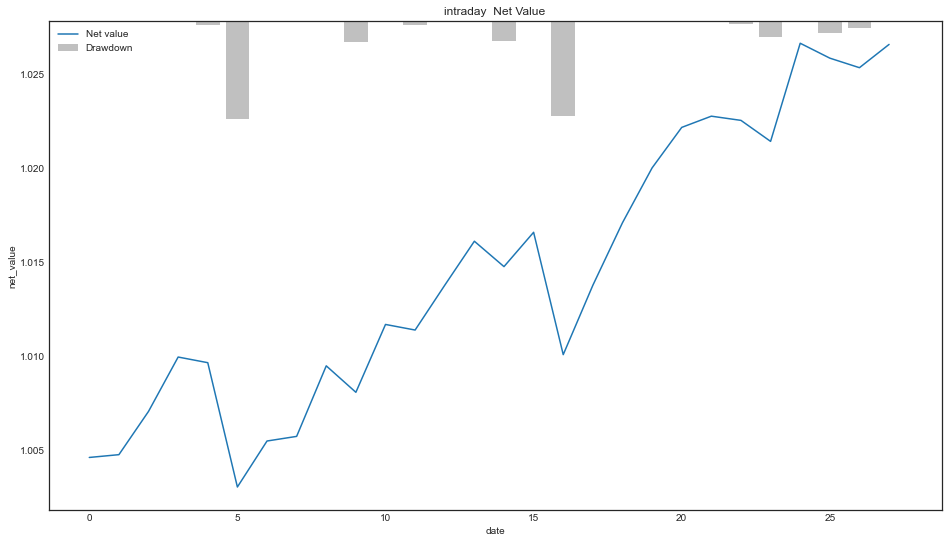

,总收益,年化收益,波动率,夏普比,最大回撤,日胜率,盈亏比,最长回撤日数,calmar比率,单期最大回撤
intraday,2.19,22.19,4.28,5.18,0.68,62.96,1.26,7,32.63,-0.66


In [38]:
oritation = 'momentum'  
# oritation = 'reverse'  
retn_list_n = []
for i, row in sig_and_pre_negative.iterrows():
    retn_list_n.append(_one_trade(row[0],row[1],oritation))
retn_n = pd.Series(retn_list_n)
net_value(retn_n)

In [39]:
sig_and_pre_positive = sig_and_pre_cleaned[sig_and_pre_cleaned['NGE_all']>0]

Y_p = sig_and_pre_positive['predict_retn'].values
X_p = sm.add_constant(sig_and_pre_positive['signal'].values)
model_p = sm.OLS(Y_p, X_p)
results_p = model_p.fit()
print(results_p.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.620
Date:                Wed, 24 May 2023   Prob (F-statistic):             0.0574
Time:                        14:38:50   Log-Likelihood:                 4066.4
No. Observations:                 947   AIC:                            -8129.
Df Residuals:                     945   BIC:                            -8119.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.599e-05      0.000     -0.242      0.8

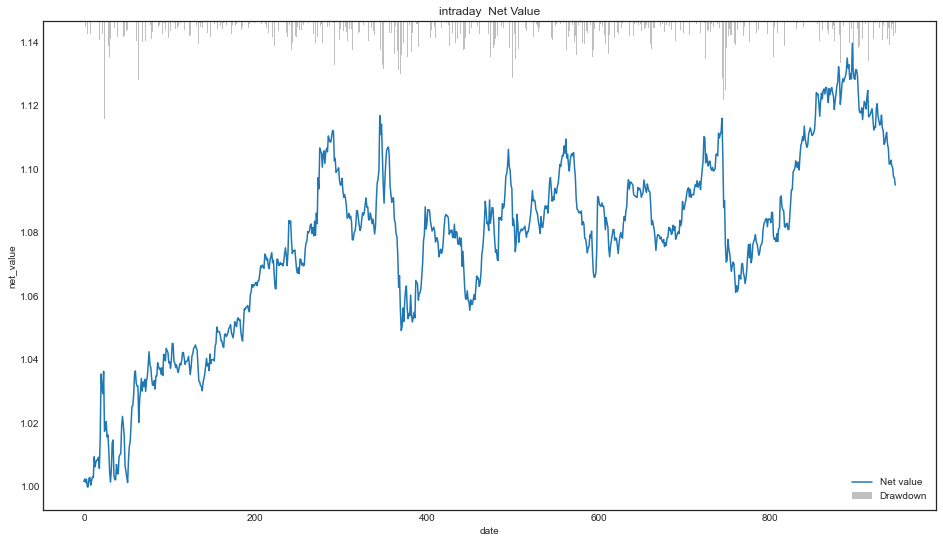

,总收益,年化收益,波动率,夏普比,最大回撤,日胜率,盈亏比,最长回撤日数,calmar比率,单期最大回撤
intraday,9.32,2.38,5.23,0.46,6.06,52.1,1.0,509,0.39,-1.82


In [40]:
oritation = 'momentum'  
# oritation = 'reverse'  
retn_list_p = []
for i, row in sig_and_pre_positive.iterrows():
    retn_list_p.append(_one_trade(row[0],row[1],oritation))
retn_p = pd.Series(retn_list_p)
net_value(retn_p)